# ExoWrap: First Atmosphere Simulation 🪐
Let's test our new Python wrapper for the ExoREM Fortran backend. We will define a hot Jupiter, run the radiative-convective equilibrium model, and plot the resulting Temperature-Pressure profile.

In [1]:
import exowrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"exowrap version: {exowrap.__version__}")

exowrap version: 0.1.0


## 1. Define Planet Parameters
We pass our physical parameters as a simple Python dictionary. `exowrap` will translate this into the complex Fortran namelist behind the scenes.

In [2]:
params = {
    "mass": 1.5,        # Planet mass in Jupiter masses
    "T_int": 400,       # Internal heat (K)
    "T_irr": 1200,      # Irradiation from the host star (K)
    "Met": 0.5,         # Metallicity [Fe/H] (log10 relative to solar)
    "f_sed": 2,         # Cloud sedimentation parameter
    "kzz": 8.0,         # Eddy diffusion coefficient (log10 cm^2/s)
    "g_1bar": 15.0      # Surface gravity at 1 bar (m/s^2)
}

## 2. Run the Simulation
This cell will create a temporary directory, build the `input.nml` file, execute the compiled Fortran `exorem.exe` binary, parse the resulting HDF5 file, and return a Pandas DataFrame.
*(Note: If the Fortran code crashes, change `keep_run_files=True` to inspect the raw output folder).*

In [11]:
# Initialize the model
# Save it to a dedicated tests folder
model = exowrap.Simulation(
    params=params, 
    output_dir="../tests/hot_jupiters/"
)

try:
    # Run the Fortran backend
    results_df = model.run()
    print("Simulation successful! Available data keys:")
    print(results_df.columns.tolist()[:15])

except RuntimeError as e:
    # If Fortran crashes, Jupyter will cleanly print the Fortran terminal output here!
    print(e)
    
    # You can also access the raw strings anytime via the model object:
    # print(model.last_stderr)

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpxbgswjez/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...


In [4]:
actual_T_int = results_df['/outputs/run_quality/actual_internal_temperature'].iloc[0]
print(f"Targeted T_int: {params['T_int']} K")
print(f"Actual achieved T_int: {actual_T_int:.2f} K")

chi_squared = results_df['/outputs/run_quality/chi2_retrieval'].iloc[0]
print(f"Final Convergence Chi^2: {chi_squared}")

Targeted T_int: 400 K
Actual achieved T_int: 400.19 K
Final Convergence Chi^2: 17709.499265608025


## 3. Plot the Temperature-Pressure Profile and spectrum
The `results_df` contains our atmosphere profiles stored as arrays within a single row. Let's extract the pressure and temperature layers and plot them. In atmospheric science, we always plot Pressure on the Y-axis, inverted (high pressure at the bottom), on a log scale.

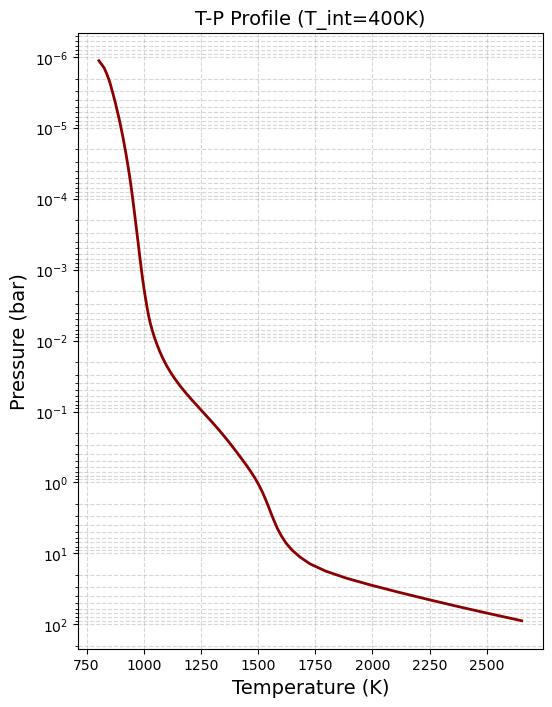

In [5]:
ax1 = exowrap.plot_tp_profile(results_df, title=f"T-P Profile (T_int={params['T_int']}K)")
plt.show()

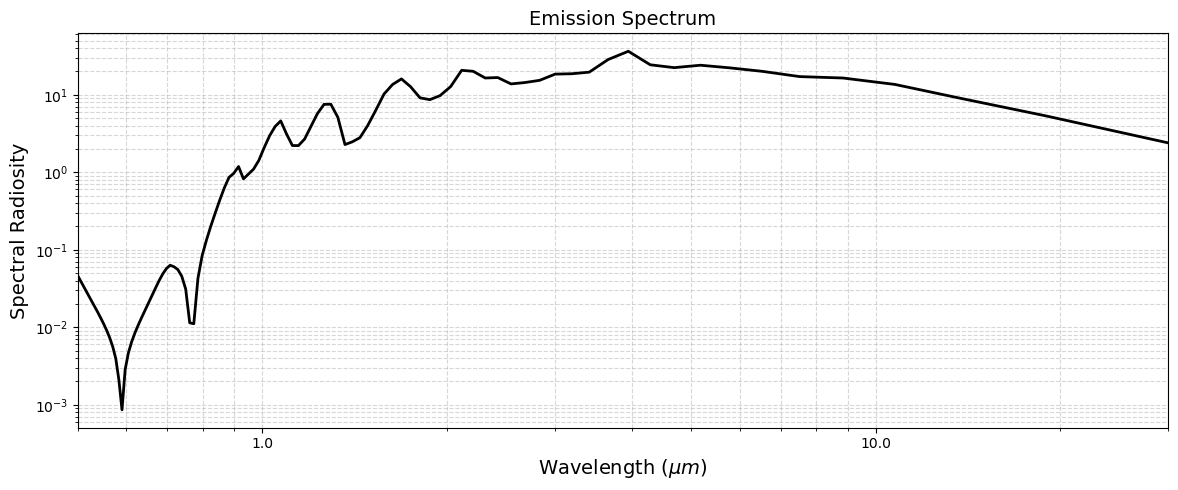

In [6]:
# And plotting the spectrum!
ax2 = exowrap.plot_emission_spectrum(results_df)

# Because our function returns the matplotlib axis, you can easily customize it afterward!
ax2.set_xlim(0.5, 30) # Zoom in on the 0.5 to 30 micron range
plt.show()

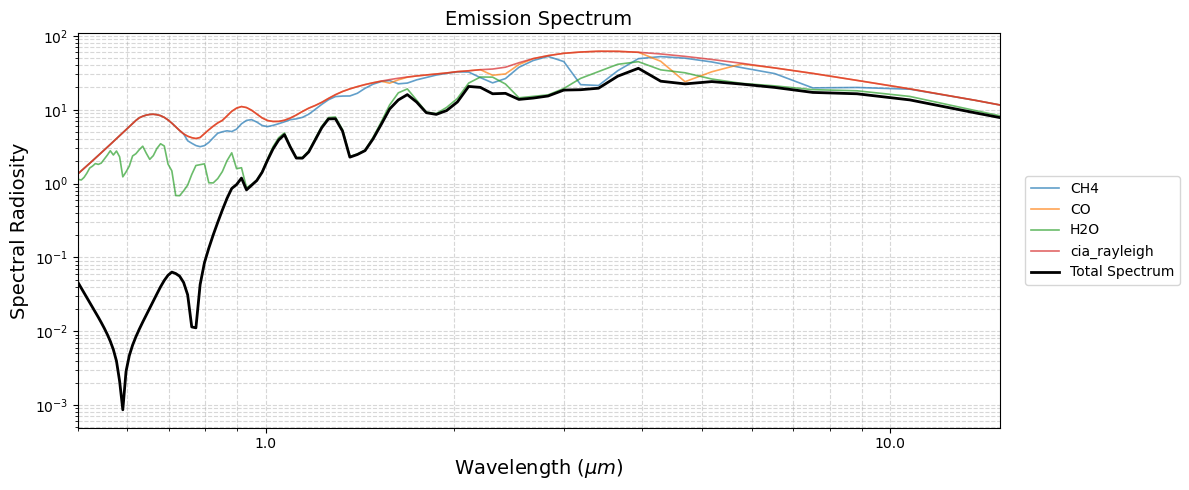

In [7]:
# Let's plot the baseline continuum (cia_rayleigh), plus water and methane, 
# and the total spectrum will be drawn on top!
mols_to_plot = ['cia_rayleigh', 'H2O', 'CH4', 'CO']

ax = exowrap.plot_emission_spectrum(results_df, contributions=mols_to_plot)

# Zoom in on the JWST range
if ax:
    ax.set_xlim(0.5, 15)
    plt.show()

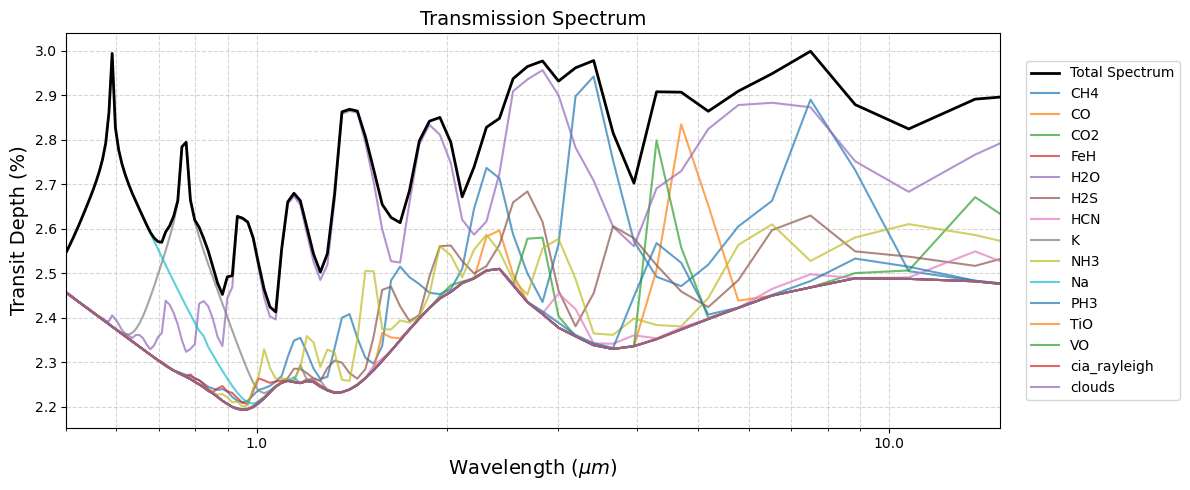

In [8]:
# Plot total spectrum and EVERY contribution available in the HDF5 file
ax = exowrap.plot_transmission_spectrum(results_df, contributions=True)
ax.set_xlim(0.5, 15)
plt.show()

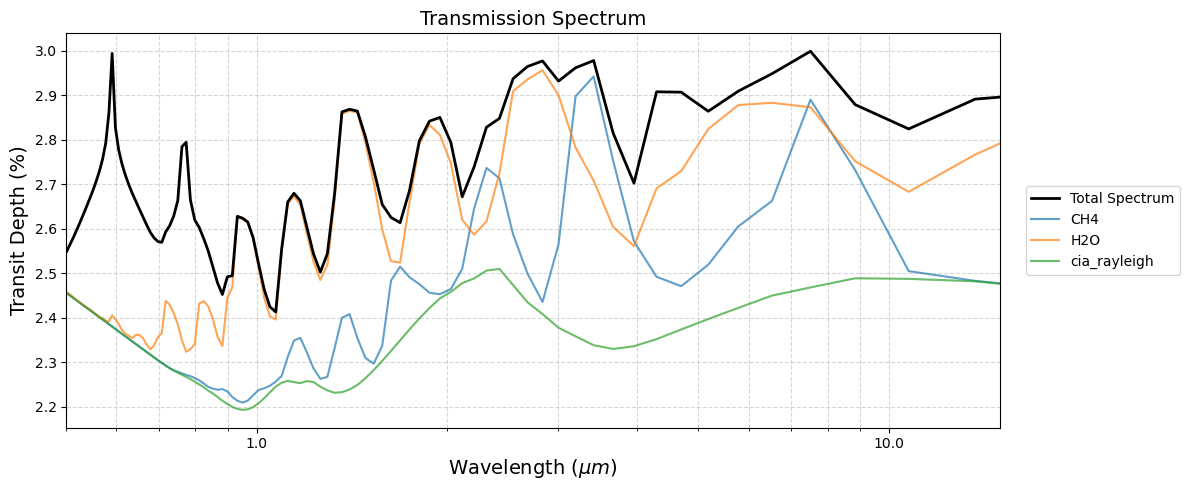

In [9]:
# Plot total spectrum alongside just Water, Methane, and the base CIA/Rayleigh scattering
mols_to_plot = ['H2O', 'CH4', 'cia_rayleigh']

ax = exowrap.plot_transmission_spectrum(results_df, contributions=mols_to_plot)
ax.set_xlim(0.5, 15)
plt.show()

<Axes: title={'center': 'Chemical Abundances (VMR)'}, xlabel='Volume Mixing Ratio (VMR)', ylabel='Pressure (bar)'>

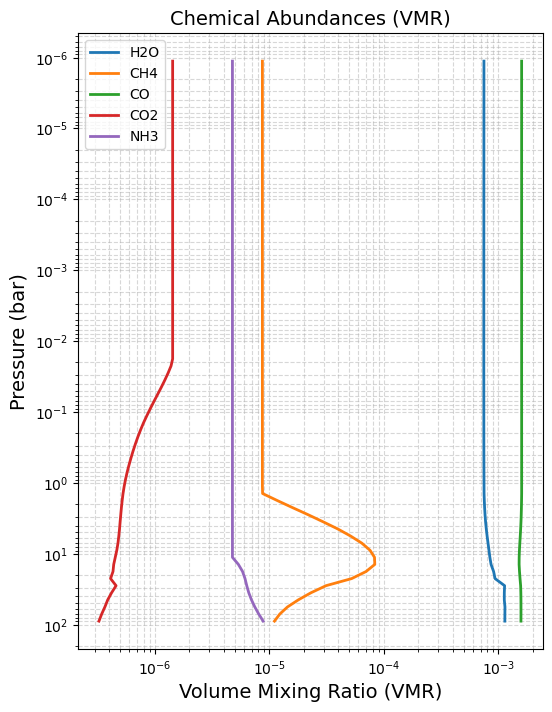

In [10]:
exowrap.plot_vmr_profile(results_df, molecules=['H2O', 'CH4', 'CO', 'CO2', 'NH3'])